# Метод функций Ляпунова

Рассмотрим систему
$$\dot{x} = f(x)$$

и её равновесие $x = 0$.

Пусть существует функция  $V(x,t)$ такая что
$$\left\{ \tag{1}
\begin{array}\\
V(x) > 0, \qquad x >0 \\
V(x) = 0, \qquad x = 0
\end{array}
\right.$$

Рассмотрим её производную по времени в силу уравнений движения ($\dot{x}$ будем заменять на $f(x)$)
$$\dot{V}(x) = \sum_{i} \frac{\partial V}{\partial x}\cdot \dot{x} = \sum_{i} \frac{\partial V}{\partial x}\cdot f(x) = \nabla{V} \cdot f(x)$$

Потребовав 

$$\nabla{V} \cdot f(x) < 0 \tag{2}$$ 

мы обеспечим сходимость траекторий к нулю.

Таким образом, существование функции $V(x)$, удовлетворяющей условиям (1) и (2) гарантирует асимптотическую устойчивость нулевого равновесия системы. Функция $V(x)$ в этом случае называется функцией Ляпунова.

http://www.math24.ru/%D0%BC%D0%B5%D1%82%D0%BE%D0%B4-%D1%84%D1%83%D0%BD%D0%BA%D1%86%D0%B8%D0%B9-%D0%BB%D1%8F%D0%BF%D1%83%D0%BD%D0%BE%D0%B2%D0%B0.html

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp 

# Пример 3 Вращательная динамика твердого тела

$$\left\{ 
\begin{array}\\
\dot{q} = \frac{1}{2} q \circ \boldsymbol{\omega} \\
\mathbf{J}\cdot\dot{\boldsymbol{\omega}} = -\boldsymbol{\omega} \times (\mathbf{J} \cdot \boldsymbol{\omega} + \mathbf{h}) + \mathbf{T}_{ctrl} \\
\dot{\mathbf{h}} = -\mathbf{T}_{ctrl}
\end{array}
\right. $$

См. https://arc.aiaa.org/doi/10.2514/3.20418 B. Wie, H. Weiss, and A. Arapostathis. Quarternion feedback regulator for spacecraft eigenaxis rotations // Journal of Guidance, Control, and Dynamics 1989 12:3, 375-380 


In [2]:
# Вспомогательные функции

def normalize(obj):

    return obj / np.linalg.norm(obj)


def cross_product(a, b):

    def check_dimensions(vec, string):

        if vec.ndim != 1:
            raise Exception("The {} input is not a vector".format(string))
        if len(vec) != 3:
            raise Exception("Wrong number of coordinates in the {0} vector: {1}, should be 3".format(string, len(vec)))

    check_dimensions(a, 'first')
    check_dimensions(b, 'second')

    return np.array([a[1]*b[2]-a[2]*b[1], a[2]*b[0]-a[0]*b[2], a[0]*b[1] - a[1]*b[0]])

def quat_product(q1, q2):

    def check_dimensions(q, string):

        if q.ndim != 1:
            raise Exception("The {} input is not a quaternion".format(string))
        if len(q) != 4:
            raise Exception("Wrong number of coordinates in the {0} quaternion: {1}, should be 4".format(string, len(q)))

    check_dimensions(q1, 'first')
    check_dimensions(q2, 'second')

    q = np.zeros(4)
    q[0] = q1[0] * q2[0] - q1[1:].dot(q2[1:])
    q[1:] = q1[0] * q2[1:] + q2[0] * q1[1:] + cross_product(q1[1:], q2[1:])

    return q

def rotate_vec_with_quat(q, vec):

    def check_dimensions(obj, is_quat):

        if obj.ndim != 1:
            raise Exception("Not a {}".format('quaternion' * is_quat + 'vector' * (1 - is_quat)))
        if len(obj) != (3 + 1 * is_quat):
            raise Exception("Wrong number of coordinates in the {0}: {1}, should be {2}"
                            .format('quaternion' * is_quat + 'vector' * (1 - is_quat), len(obj), 3 + 1 * is_quat))

    check_dimensions(q, True)
    check_dimensions(vec, False)

    q = quat_conjugate(q)

    qxvec = cross_product(q[1:], vec)

    return q[1:].dot(vec) * q[1:] + q[0]**2. * vec + 2. * q[0] * qxvec + cross_product(q[1:], qxvec)

def quat2rpy(q0, q1, q2, q3):

    roll = np.arctan2(2. * (q0 * q1 + q2 * q3), 1. - 2. * (q1**2 + q2**2))
    pitch = np.arcsin(2. * (q0 * q2 - q1 * q3))
    yaw = np.arctan2(2. * (q0 * q3 + q1 * q2), 1. - 2. * (q2**2 + q3**2))

    return [roll, pitch, yaw]

def quat2rpy_deg(q0, q1, q2, q3):
    
    norm_q = np.linalg.norm([q0, q1, q2, q3]) 
    q0, q1, q2, q3 = q0/norm_q, q1/norm_q, q2/norm_q, q3/norm_q 
    

    roll = np.arctan2(2. * (q0 * q1 + q2 * q3), 1. - 2. * (q1**2 + q2**2))*180/np.pi
    pitch = np.arcsin(2. * (q0 * q2 - q1 * q3))*180/np.pi
    yaw = np.arctan2(2. * (q0 * q3 + q1 * q2), 1. - 2. * (q2**2 + q3**2))*180/np.pi

    return [roll, pitch, yaw]

def quat_conjugate(q):

    q_new = np.copy(q)
    q_new[1:] *= -1.

    return q_new

В качестве функции Ляпунова можно выбрать
$$V(\delta q, \delta\boldsymbol{\omega}) = \frac{1}{2}(\delta\boldsymbol{\omega}, \delta\boldsymbol{\omega}) + 2 k_q\cdot(1 - \delta q_0)$$

где $\delta q$ и $\delta\boldsymbol{\omega}$ - кватернион ошибки и ошибка по угловой скорости:
$$\left\{ 
\begin{array}\\
\delta q = \tilde{q}_{req} \circ q \\
\delta \boldsymbol{\omega} = \boldsymbol{\omega} - \boldsymbol{\omega}_{req}
\end{array}
\right. $$
а ${q}_{req}$ и $\boldsymbol{\omega}_{req}$ - режим, который должна обеспечить система управления.

Закон управления, соответствующий выбранной функции Ляпунова:
$$
\mathbf{T}_{ctrl} = \boldsymbol{\omega} \times (\mathbf{J} \cdot \boldsymbol{\omega} + \mathbf{h}) - k_{\omega}\cdot \mathbf{J}\cdot \delta\boldsymbol{\omega} - k_q \cdot \mathbf{J} \cdot \delta \mathbf{q},
$$
где $\delta \mathbf{q}$ - векторная часть кватерниона ошибки, а $k_{\omega}, k_q > 0$ - настраиваемые коэффициенты регулятора.

In [3]:
def ctrl_torque(quat, omega, h, ctrl, J):
       
    dw = omega - ctrl.omega_req
    dq = quat_product(quat_conjugate(ctrl.q_req), quat)
    trq_ctrl = np.zeros(3)
    
    trq_ctrl = cross_product(omega, J.dot(omega)  + h) - ctrl.kw * J.dot(dw) - ctrl.kq * J.dot(dq[1:])
            
    if np.max(np.abs(trq_ctrl)) > ctrl.trq_max:
        trq_ctrl *= ctrl.trq_max / np.max(np.abs(trq_ctrl))  
        
    for i in range(3):
        if np.abs(h[i]) / ctrl.h_max > 0.99 and trq_ctrl[i] * h[i] < 0:
            trq_ctrl[i] = 0        
        
    return trq_ctrl

def rhs(t, x, sat, ctrl):

    quat = x[:4] / np.linalg.norm(x[:4])
    omega = x[4:7]
    h = x[7:]
     
    control_action = ctrl_torque(quat, omega, h, ctrl, sat.J)        

    x_dot = np.zeros(10)

    x_dot[0] = -0.5 * quat[1:].dot(omega)
    x_dot[1:4] = 0.5 * (quat[0] * omega + cross_product(quat[1:], omega))
    x_dot[4:7] = sat.J_inv.dot(control_action - cross_product(omega, sat.J.dot(omega) + h))
    x_dot[7:]= -control_action
        
    return x_dot

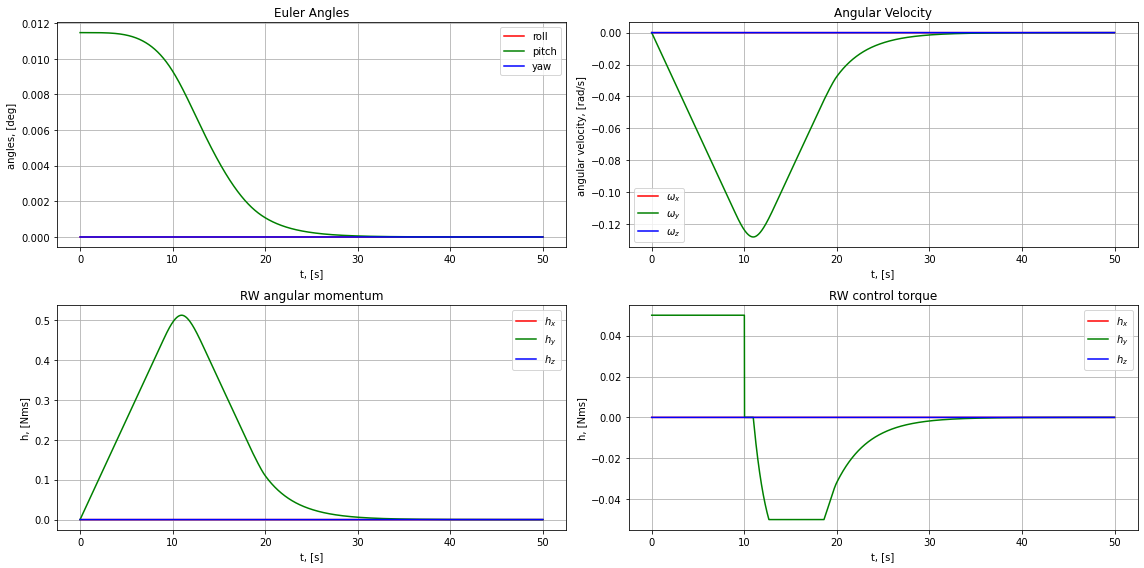

In [4]:
class Parameters(object):
    pass

sat = Parameters()
sat.J = np.diag(np.array([3, 4, 5]))
sat.J_inv = np.linalg.inv(sat.J)

a = 0.32
ctrl = Parameters()
ctrl.kw = 2 * a
ctrl.kq = 2 * a**2
ctrl.trq_max = 0.05
ctrl.h_max = 0.5
ctrl.omega_req = np.zeros(3)
ctrl.q_req = np.array([1., 0., 0., 0.])

alpha_0 = np.pi / 4
x_0 = np.array([np.cos(alpha_0), 0, np.sin(alpha_0), 0, 0, 0, 0, 0, 0, 0])

t0 = 0.
tf = 50.
t_eval = np.arange(t0, tf, 0.01)

sol = solve_ivp(lambda t, x: rhs(t, x, sat, ctrl), (t0,tf), x_0, t_eval = t_eval)
x = sol.y.T
t = sol.t
roll, pitch, yaw = quat2rpy_deg(x[1:,0], x[1:,1], x[1:,2], x[1:,3])

control = np.zeros((np.size(t), 3))
for i in range(np.size(t)):
    control[i] = ctrl_torque(x[i, 0:4], x[i, 4:7], x[i, 7:], ctrl, sat.J)


roll, pitch, yaw = quat2rpy_deg(x[:,0], x[:,1], x[:,2], x[:,3])
   
fig1 = plt.figure(figsize=(16,8))
ax1 = fig1.add_subplot(2,2,1)

ax1.set_title("Euler Angles")
ax1.plot(t, roll, label = 'roll', color = 'red')
ax1.plot(t, pitch, label = 'pitch', color = 'green')
ax1.plot(t, yaw, label = 'yaw', color = 'blue')
ax1.set_ylabel(r'angles, [deg]')
ax1.set_xlabel(r't, [s]')
ax1.grid(True)
ax1.legend()

ax2 = fig1.add_subplot(2,2,2)

ax2.set_title("Angular Velocity")
ax2.plot(t, x[:,4], label = '$\omega_x$', color = 'red')
ax2.plot(t, x[:,5], label = '$\omega_y$', color = 'green')
ax2.plot(t, x[:,6], label = '$\omega_z$', color = 'blue')
ax2.set_ylabel(r'angular velocity, [rad/s]')
ax2.set_xlabel(r't, [s]')
ax2.grid(True)
ax2.legend()

ax3 = fig1.add_subplot(2,2,3)

ax3.set_title("RW angular momentum")
ax3.plot(t, x[:,7], label = '$h_x$', color = 'red')
ax3.plot(t, x[:,8], label = '$h_y$', color = 'green')
ax3.plot(t, x[:,9], label = '$h_z$', color = 'blue')
ax3.set_ylabel(r'h, [Nms]')
ax3.set_xlabel(r't, [s]')
ax3.grid(True)
ax3.legend()

ax4 = fig1.add_subplot(2,2,4)

ax4.set_title("RW control torque")
ax4.plot(t, -control[:,0], label = '$h_x$', color = 'red')
ax4.plot(t, -control[:,1], label = '$h_y$', color = 'green')
ax4.plot(t, -control[:,2], label = '$h_z$', color = 'blue')
ax4.set_ylabel(r'h, [Nms]')
ax4.set_xlabel(r't, [s]')
ax4.grid(True)
ax4.legend()

plt.tight_layout()

## Управление ориентацией с обходом запрещённых зон:

Искуственный потенциал

$f = \frac{\lambda_i}{\cos{\alpha_i} - \mathbf{e}_o\cdot\mathbf{e}_f},$

где $\mathbf{e}_o$ - направление оси, заданноя в осях КА, $\mathbf{e}_f$ - направлениие в инерциальных осях, с которым не дожно совпадать $\mathbf{e}_o$ (например, нежелательно направлять чувствительную оптику на Солнце), $\alpha_i$ - угол раствора конуса с осью $\mathbf{e}_o$, определяющего нежелательные ориентации.

В качестве функции Ляпунова можно выбрать
$$V(\delta q, \delta\boldsymbol{\omega}) = \left(\frac{1}{2}(\delta\boldsymbol{\omega}, \delta\boldsymbol{\omega}) + 2 k_q\cdot(1 - \delta q_0)\right)\cdot\frac{\lambda_i}{\cos{\alpha_i} - \mathbf{e}_o\cdot\mathbf{e}_f}$$

где $\delta q$ и $\delta\boldsymbol{\omega}$ - кватернион ошибки и ошибка по угловой скорости:
$$\left\{ 
\begin{array}\\
\delta q = \tilde{q}_{req} \circ q \\
\delta \boldsymbol{\omega} = \boldsymbol{\omega} - \boldsymbol{\omega}_{req}
\end{array}
\right. $$
а ${q}_{req}$ и $\boldsymbol{\omega}_{req}$ - режим, который должна обеспечить система управления.

Закон управления, соответствующий выбранной функции Ляпунова:
$$
\mathbf{T}_{ctrl} = \boldsymbol{\omega} \times (\mathbf{J} \cdot \boldsymbol{\omega} + \mathbf{h}) - k_{\omega}\cdot \frac{\cos{\alpha_i} - \mathbf{e}_o\cdot\mathbf{e}_f}{\lambda_i} \cdot \mathbf{J}\cdot \delta\boldsymbol{\omega} - k_q \cdot \mathbf{J} \cdot \delta \mathbf{q} - \mathbf{e}_o\times\mathbf{e}_f\frac{(\delta\boldsymbol{\omega}, \delta\boldsymbol{\omega})+2k_q\cdot(1 - \delta q_0)}{\cos{\alpha_i} - \mathbf{e}_o\cdot\mathbf{e}_f},
$$
где $\delta \mathbf{q}$ - векторная часть кватерниона ошибки, а $k_{\omega}, k_q > 0$ - настраиваемые коэффициенты регулятора.

In [18]:
def ctrl_torque_a(quat, omega, h, ctrl, J):
       
    dw = omega - ctrl.omega_req
    dq = quat_product(quat_conjugate(ctrl.q_req), quat)
    trq_ctrl = np.zeros(3)
    
    trq_gyro = cross_product(omega, J.dot(omega) + h)
    
    e_f = rotate_vec_with_quat(quat, ctrl.e_f)
    
    barrier_w = np.cos(ctrl.alpha_f) -  ctrl.e_o.dot(e_f)
    
    barrier_0 = cross_product(ctrl.e_o, e_f) * (dw.dot(J.dot(dw)) + 2 * ctrl.kq * (1 - dq[0])) / barrier_w
    
    trq_ctrl =  trq_gyro - ctrl.kq * J.dot(dq[1:]) - ctrl.kw * dw * barrier_w / ctrl.lambda_f  - barrier_0
            
    if np.max(np.abs(trq_ctrl)) > ctrl.trq_max:
        trq_ctrl *= ctrl.trq_max / np.max(np.abs(trq_ctrl))  
        
    for i in range(3):
        if np.abs(h[i]) / ctrl.h_max > 0.99 and trq_ctrl[i] * h[i] < 0:
            trq_ctrl[i] = 0        
        
    return trq_ctrl


def rhs_a(t, x, sat, ctrl):

    quat = x[:4] / np.linalg.norm(x[:4])
    omega = x[4:7]
    h = x[7:]
     
    control_action = ctrl_torque_a(quat, omega, h, ctrl, sat.J)        

    x_dot = np.zeros(10)

    x_dot[0] = -0.5 * quat[1:].dot(omega)
    x_dot[1:4] = 0.5 * (quat[0] * omega + cross_product(quat[1:], omega))
    x_dot[4:7] = sat.J_inv.dot(control_action - cross_product(omega, sat.J.dot(omega) + h))
    x_dot[7:]= -control_action
        
    return x_dot

In [ ]:
class Parameters(object):
    pass

sat = Parameters()
sat.J = np.diag(np.array([3, 4, 5]))
sat.J_inv = np.linalg.inv(sat.J)

ctrl_a = Parameters()
ctrl_a.kw = 3
ctrl_a.kq = 0.2
ctrl_a.trq_max = 0.05
ctrl_a.h_max = 0.5
ctrl_a.omega_req = np.zeros(3)
ctrl_a.q_req = np.array([1., 0., 0., 0.])
ctrl_a.e_o = np.array([0., 0., 1.])
ctrl_a.e_f = normalize(np.array([1., -0.2, 1.]))
ctrl_a.alpha_f = 0.2
ctrl_a.lambda_f = 0.05

alpha_0 = np.pi / 4
x_0 = np.array([np.cos(alpha_0), 0, np.sin(alpha_0), 0, 0, 0, 0, 0, 0, 0])

t0 = 0.
tf = 500
t_eval = np.arange(t0, tf, 0.01)

sol_a = solve_ivp(lambda t, x: rhs_a(t, x, sat, ctrl_a), (t0, tf), x_0, t_eval = t_eval)
x_a = sol_a.y.T
t_a = sol_a.t

control_a = np.zeros((np.size(t_a), 3))
for i in range(np.size(t_a)):
    control_a[i] = ctrl_torque_a(x_a[i, 0:4], x_a[i, 4:7], x_a[i, 7:], ctrl_a, sat.J)


roll, pitch, yaw = quat2rpy_deg(x_a[:,0], x_a[:,1], x_a[:,2], x_a[:,3])
   
fig1 = plt.figure(figsize=(16,8))
ax1 = fig1.add_subplot(2,2,1)

ax1.set_title("Euler Angles")
ax1.plot(t_a, roll, label = 'roll', color = 'red')
ax1.plot(t_a, pitch, label = 'pitch', color = 'green')
ax1.plot(t_a, yaw, label = 'yaw', color = 'blue')
ax1.set_ylabel(r'angles, [deg]')
ax1.set_xlabel(r't, [s]')
ax1.grid(True)
ax1.legend()

ax2 = fig1.add_subplot(2,2,2)

ax2.set_title("Angular Velocity")
ax2.plot(t_a, x_a[:,4], label = '$\omega_x$', color = 'red')
ax2.plot(t_a, x_a[:,5], label = '$\omega_y$', color = 'green')
ax2.plot(t_a, x_a[:,6], label = '$\omega_z$', color = 'blue')
ax2.set_ylabel(r'angular velocity, [rad/s]')
ax2.set_xlabel(r't, [s]')
ax2.grid(True)
ax2.legend()

ax3 = fig1.add_subplot(2,2,3)

ax3.set_title("RW angular momentum")
ax3.plot(t_a, x_a[:,7], label = '$h_x$', color = 'red')
ax3.plot(t_a, x_a[:,8], label = '$h_y$', color = 'green')
ax3.plot(t_a, x_a[:,9], label = '$h_z$', color = 'blue')
ax3.set_ylabel(r'h, [Nms]')
ax3.set_xlabel(r't, [s]')
ax3.grid(True)
ax3.legend()

ax4 = fig1.add_subplot(2,2,4)

ax4.set_title("RW control torque")
ax4.plot(t_a, -control_a[:,0], label = '$h_x$', color = 'red')
ax4.plot(t_a, -control_a[:,1], label = '$h_y$', color = 'green')
ax4.plot(t_a, -control_a[:,2], label = '$h_z$', color = 'blue')
ax4.set_ylabel(r'h, [Nms]')
ax4.set_xlabel(r't, [s]')
ax4.grid(True)
ax4.legend()

plt.tight_layout()

In [ ]:
from mayavi import mlab #pip install mayavi

e_x = ctrl_a.e_o

e_x_i = np.zeros((np.size(t), 3))
e_x_i_a = np.zeros((np.size(t_a), 3))
for i in range(np.size(t)):
    e_x_i[i, :] = rotate_vec_with_quat(quat_conjugate(x[i, 0:4]), e_x)
for i in range(np.size(t_a)):
    e_x_i_a[i, :] = rotate_vec_with_quat(quat_conjugate(x_a[i, 0:4]), e_x)

# Create a sphere
phi, theta = np.mgrid[0:np.pi:101j, 0:2 * np.pi:101j]
restricted_zone_x = (np.sin(ctrl_a.alpha_f) * np.cos(np.arange(0, 2 * np.pi, 0.5)))
restricted_zone_y = np.sin(ctrl_a.alpha_f) * np.sin(np.arange(0, 2 * np.pi, 0.5))
restricted_zone_z = np.cos(ctrl_a.alpha_f) * np.ones(np.size(restricted_zone_y))
restricted_zone = np.array([restricted_zone_x, restricted_zone_y, restricted_zone_z])

theta_f = np.arccos(ctrl_a.e_f[2])
phi_f = np.arctan2(ctrl_a.e_f[1], ctrl_a.e_f[0])
rotation_theta = np.array([[np.cos(theta_f), 0., np.sin(theta_f)],
                           [0., 1., 0.],
                           [-np.sin(theta_f), 0., np.cos(theta_f)]])
rotation_phi = np.array([[np.cos(phi_f), -np.sin(phi_f), 0.],
                         [np.sin(phi_f), np.cos(phi_f), 0.],
                         [0., 0., 1.]])

restricted_zone = rotation_phi.dot(rotation_theta).dot(restricted_zone)
rz_x = restricted_zone[0, :]
rz_y = restricted_zone[1, :] 
rz_z = restricted_zone[2, :]

mlab.figure(1, bgcolor=(1, 1, 1), fgcolor=(0, 0, 0), size=(400, 300))
mlab.clf()

mlab.mesh(np.sin(phi) * np.cos(theta), np.sin(phi) * np.sin(theta), np.cos(phi), color=(0.8, 0.5, 0.), opacity = 0.5)
#mlab.axes(xlabel='x', ylabel='y', zlabel='z', ranges=(0, 1.5, 0, 1.5, 0, 1.5), nb_labels = 4)
mlab.points3d(rz_x, rz_y, rz_z, color = (0., 0., 1.), scale_factor=0.025)
mlab.plot3d(e_x_i[:, 0], e_x_i[:, 1], e_x_i[:, 2], tube_radius = 0.01)
mlab.plot3d(e_x_i_a[:, 0], e_x_i_a[:, 1], e_x_i_a[:, 2], color = (0.8, 0., 0.), tube_radius = 0.01)

mlab.plot3d([0, 1.5], [0, 0], [0, 0], color = (1., 0., 0.))
mlab.plot3d([0, 0], [0, 1.5], [0, 0], color = (0., 1., 0.))
mlab.plot3d([0, 0], [0, 0], [0, 1.5], color = (0., 0., 1.))

mlab.show()

In [48]:
restricted_zone

array([[ 0.82257905,  0.7872024 ,  0.72709288,  0.65696741,  0.59399514,
         0.55359389,  0.54565528,  0.57212297,  0.62651674,  0.6955191 ,
         0.76223587,  0.81033245,  0.82803313],
       [ 0.16451581,  0.2545739 ,  0.31590376,  0.33348972,  0.3030261 ,
         0.23197148,  0.1377225 ,  0.04335459, -0.02802768, -0.05894746,
        -0.04183449,  0.01912137,  0.108996  ],
       [ 0.54433285,  0.56169789,  0.60954143,  0.67614971,  0.7452147 ,
         0.79982688,  0.82661528,  0.81902118,  0.77890386,  0.71608545,
         0.64594609,  0.58565834,  0.54998274]])

In [46]:
restricted_zone = np.array([0,0,1])

theta_f = np.arccos(ctrl_a.e_f[2])
phi_f = np.arctan2(ctrl_a.e_f[1], ctrl_a.e_f[0])
rotation_theta = np.array([[np.cos(theta_f), 0., np.sin(theta_f)],
                           [0., 1., 0.],
                           [-np.sin(theta_f), 0., np.cos(theta_f)]])
rotation_phi = np.array([[np.cos(phi_f), -np.sin(phi_f), 0.],
                         [np.sin(phi_f), np.cos(phi_f), 0.],
                         [0., 0., 1.]])

restricted_zone = rotation_phi.dot(rotation_theta).dot(restricted_zone)
restricted_zone, theta_f * 180 / np.pi, phi_f * 180 / np.pi

(array([0.70014004, 0.14002801, 0.70014004]),
 45.56175932885021,
 11.309932474020213)

# Возможные задачи:

1. Colin R. Mclnnes -- Large angle slew maneuvers with autonomous sun vector avoidance
https://arc.aiaa.org/doi/10.2514/3.21283


2. Ahmed Mahfouz -- Hybrid Attitude Control for Nano-Spacecraft: Reaction Wheel Failure and Singularity Handling
https://arc.aiaa.org/doi/10.2514/1.G005525


3. Zachary Manchester -- Lyapunov-Based Control for Flat-Spin Recovery and Spin Inversion of Spin-Stabilized Spacecraft
https://arc.aiaa.org/doi/abs/10.2514/6.2016-5644


4. Hadi Ravanbakhsh and Sriram Sankaranarayanan - Learning Lyapunov (Potential) Functions from Counterexamples and Demonstrations
https://arxiv.org/pdf/1705.09619.pdf


5. P Gurfil Non-linear missile guidance synthesis using control Lyapunov functions
https://doi.org/10.1243/095441005X9085